In [1]:
from google.colab import drive
drive.mount("/content/drive")
import shutil
from google.colab import files

Mounted at /content/drive


In [2]:
import cv2
import math
import os
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import matplotlib.colors as colors


In [3]:
data_path = "/content/drive/MyDrive/Location_Season_Data/"

In [4]:
df = pd.read_csv(data_path + "Location_Season_Pressure_first_3_year_ROI.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,season,Name,Day,Class
0,0.475692,0.473846,0.471385,0.468923,0.465846,0.462769,0.460308,0.456615,0.453538,0.450462,...,0.435077,0.443077,1,1,1,0,2,116_c7_cp2_100_32,116,0
1,0.464615,0.463385,0.462769,0.460923,0.460308,0.457846,0.455385,0.452923,0.451077,0.450462,...,0.454769,0.475077,1,0,1,0,2,125_c3_cp2_49_32,125,0
2,0.248615,0.243692,0.240000,0.237538,0.235692,0.234462,0.234462,0.235692,0.237538,0.240615,...,0.246154,0.264615,1,0,0,0,2,120_c1_cp2_31_29,120,0
3,0.552000,0.544000,0.536615,0.529846,0.524923,0.521846,0.520000,0.519385,0.520615,0.523077,...,0.475077,0.492923,1,1,1,0,2,127_c3_cp3_96_38,127,0
4,0.248615,0.243692,0.240000,0.237538,0.235692,0.234462,0.234462,0.235692,0.237538,0.240615,...,0.246154,0.264615,1,0,0,0,2,120_c2_cp2_31_29,120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,0.930833,0.935248,0.939601,0.937135,0.942242,0.940599,0.940394,0.935167,0.934217,0.936547,...,0.948077,0.953185,1,0,1,1,3,997_c12_cp2_62_59,997,3
1064,0.869459,0.873418,0.876279,0.877193,0.879589,0.879725,0.879310,0.874263,0.870889,0.869159,...,0.911058,0.919884,1,0,1,1,3,998_c12_cp2_37_48,998,2
1065,0.759864,0.772639,0.783731,0.791910,0.800783,0.806087,0.810837,0.810413,0.810015,0.810133,...,0.813462,0.813224,1,1,1,0,3,999_c11_cp2_102_34,999,2
1066,0.812957,0.820837,0.826595,0.829435,0.835047,0.838979,0.843350,0.843320,0.844379,0.848008,...,0.909615,0.921332,1,0,1,0,3,999_c11_cp3_37_44,999,2


In [5]:
X = df.drop(columns = ["Name", "Day", "Class"])
Y = df["Class"]

# **SOM**

In [6]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled
#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [7]:
num_rows = 33
num_cols = 33
max_m_dsitance = 7
max_learning_rate = 0.75
max_steps = 150000

In [8]:
#main function

train_x_norm = minmax_scaler(X) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
#np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [9]:
label_data = np.array(Y)
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

sample data:  1000


In [10]:
map_table = {}
for i in range(len(map)):
    for j in range(len(map[0])):
        if len(map[i][j]) == 0:
            map_table[i, j] = [None]
        else:
            hash_table = {}
            for k in map[i][j]:
                if k in hash_table:
                    hash_table[k] += 1
                else:
                    hash_table[k] = 1
            for key, value in hash_table.items():
                percentage = [key, round((value / len(map[i][j])), 2)]
                if (i, j) not in map_table:
                    map_table[i, j] = []
                map_table[i, j].append(percentage)


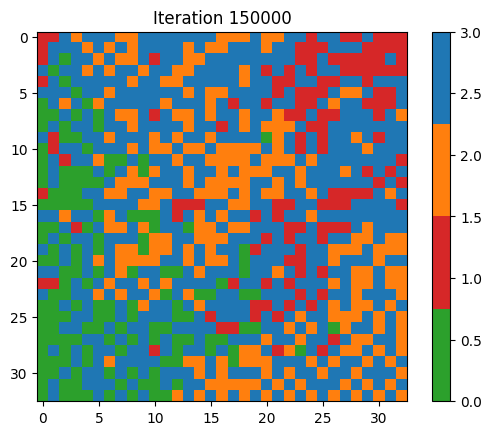

In [11]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [12]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data_frame = minmax_scaler(X) # normalisation

winner_labels = []
pre_labels = []

for t in range(data_frame.shape[0]):
  winner = winning_neuron(data_frame, t, som, num_rows, num_cols)
  row = winner[0]
  col = winner[1]
  pred = map_table[row, col]
  predicted = label_map[row][col]
  pre_labels.append(pred)
  winner_labels.append(predicted)

In [13]:
print("Accuracy: ", accuracy_score(np.array(winner_labels), np.array(Y)))

Accuracy:  0.9391385767790262


In [16]:
print(confusion_matrix(np.array(winner_labels), np.array(Y)))

[[257   0  15   0]
 [  0 235   2   6]
 [ 10   4 386  16]
 [  0   1  11 125]]


In [14]:
df["pred"] = np.array(winner_labels)

In [17]:
df_1st = df[df["Day"] <= 365]
df_2nd = df[(df["Day"] <= 730) & (df["Day"] > 365)]
df_3rd = df[(df["Day"] <= 1095) & (df["Day"] > 730)]

In [20]:
print("Accuracy_1st_year: ", accuracy_score(np.array(df_1st["pred"]), np.array(df_1st["Class"])))
print("Confusion Matrix: \n", confusion_matrix(np.array(df_1st["pred"]), np.array(df_1st["Class"])))

Accuracy_1st_year:  0.963302752293578
Confusion Matrix: 
 [[ 73   0   3   0]
 [  0  82   0   2]
 [  2   0 137   4]
 [  0   1   0  23]]


In [21]:
print("Accuracy_2nd_year: ", accuracy_score(np.array(df_2nd["pred"]), np.array(df_2nd["Class"])))
print("Confusion Matrix: \n", confusion_matrix(np.array(df_2nd["pred"]), np.array(df_2nd["Class"])))

Accuracy_2nd_year:  0.9414634146341463
Confusion Matrix: 
 [[101   0   8   0]
 [  0  77   2   2]
 [  2   1 172   4]
 [  0   0   5  36]]


In [22]:
print("Accuracy_3rd_year: ", accuracy_score(np.array(df_3rd["pred"]), np.array(df_3rd["Class"])))
print("Confusion Matrix: \n", confusion_matrix(np.array(df_3rd["pred"]), np.array(df_3rd["Class"])))

Accuracy_3rd_year:  0.9123867069486404
Confusion Matrix: 
 [[83  0  4  0]
 [ 0 76  0  2]
 [ 6  3 77  8]
 [ 0  0  6 66]]
